In [ ]:
#####################################################
### --- We modify the dataloader in this block ---###
#####################################################

from __future__ import print_function
import torchvision.datasets.vision as vision
import warnings
from PIL import Image
import os
import os.path
import random
import numpy as np
import torch
import codecs
# from torchvision.datasets.utils import download_url, download_and_extract_archive, extract_archive, \
#    makedir_exist_ok, verify_str_arg
from torchvision.datasets.utils import download_url, download_and_extract_archive, extract_archive, \
    verify_str_arg

# This class is copied from torchvision.datasets.MNIST
class MyMNIST(vision.VisionDataset):

    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False, limit_data=None):
        super(MyMNIST, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        self.train = train  # training set or test set

        # ------- We can ingore this block -------
        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        # -----------------------------------------------

        # We change the lines below; these specify how the data are loaded.
        # self.data contain images (type 'torch.Tensor' of [num_images, H, W]) 
        # self.targets contain labels (class ids) (type 'torch.Tensor' of [num_images]) 
        # images and labels are stored in the same 
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

        # We use only the images and lables whose indeces are in the range of 0..limit_data-1.
        if not limit_data is None:
          self.data    = self.data[   :limit_data, :,:]
          self.targets = self.targets[:limit_data]
          if self.train:
            print("[WRN]: Trainig Data is limited, only the first "+str(self.data.size(0))+" samples will be used.")
          else:
            print("[WRN]: Test Data is limited, only the first "   +str(self.data.size(0))+" samples will be used.")            


    def __getitem__(self, index):
        # We extract the image and label of the specified 'index'.
        img, target = self.data[index], int(self.targets[index])

        # Prepare for self.transform below.
        img = Image.fromarray(img.numpy(), mode='L')

        # Transform img.
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.data)


# ---------------------- We just leave the code from here as original -----------------
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/processed/training.pt``
            and  ``MNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.processed_folder,
                                            self.training_file)) and
                os.path.exists(os.path.join(self.processed_folder,
                                            self.test_file)))
        
    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""

        if self._check_exists():
            return

        # makedir_exist_ok(self.raw_folder)
        # makedir_exist_ok(self.processed_folder)
        os.makedirs(self.raw_folder, exist_ok=True)
        os.makedirs(self.processed_folder, exist_ok=True)

        # download files
        for url in self.urls:
            filename = url.rpartition('/')[2]
            download_and_extract_archive(url, download_root=self.raw_folder, filename=filename)

        # process and save as torch files
        print('Processing...')

        training_set = (
            read_image_file(os.path.join(self.raw_folder, 'train-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            read_image_file(os.path.join(self.raw_folder, 't10k-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")

def read_label_file(path):
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 1)
    return x.long()


def read_image_file(path):
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 3)
    return x

def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)


def open_maybe_compressed_file(path):
    """Return a file object that possibly decompresses 'path' on the fly.
       Decompression occurs when argument `path` is a string and ends with '.gz' or '.xz'.
    """
    if not isinstance(path, torch._six.string_classes):
        return path
    if path.endswith('.gz'):
        import gzip
        return gzip.open(path, 'rb')
    if path.endswith('.xz'):
        import lzma
        return lzma.open(path, 'rb')
    return open(path, 'rb')


def read_sn3_pascalvincent_tensor(path, strict=True):
    """Read a SN3 file in "Pascal Vincent" format (Lush file 'libidx/idx-io.lsh').
       Argument may be a filename, compressed filename, or file object.
    """
    # typemap
    if not hasattr(read_sn3_pascalvincent_tensor, 'typemap'):
        read_sn3_pascalvincent_tensor.typemap = {
            8: (torch.uint8, np.uint8, np.uint8),
            9: (torch.int8, np.int8, np.int8),
            11: (torch.int16, np.dtype('>i2'), 'i2'),
            12: (torch.int32, np.dtype('>i4'), 'i4'),
            13: (torch.float32, np.dtype('>f4'), 'f4'),
            14: (torch.float64, np.dtype('>f8'), 'f8')}
    # read
    with open_maybe_compressed_file(path) as f:
        data = f.read()
    # parse
    magic = get_int(data[0:4])
    nd = magic % 256
    ty = magic // 256
    assert nd >= 1 and nd <= 3
    assert ty >= 8 and ty <= 14
    m = read_sn3_pascalvincent_tensor.typemap[ty]
    s = [get_int(data[4 * (i + 1): 4 * (i + 2)]) for i in range(nd)]
    parsed = np.frombuffer(data, dtype=m[1], offset=(4 * (nd + 1)))
    assert parsed.shape[0] == np.prod(s) or not strict
    return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
############################################
### --- Define a LeNet in this block --- ###
############################################
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
  def __init__(self, input_dim=1, num_class=10):
    super(LeNet, self).__init__()

    # Convolutional layers
    self.conv1 = nn.Conv2d(input_dim, 20,  kernel_size=5, stride=1, padding=0) 
    self.bn1 = nn.BatchNorm2d(20)
    self.conv2 = nn.Conv2d(20,    50,  kernel_size=5, stride=1, padding=0) 
    self.bn2 = nn.BatchNorm2d(50)
    
    # Fully connected layers
    self.fc1 = nn.Linear(800, 500)
    #self.bn3 = nn.BatchNorm1d(500)
    self.fc2 = nn.Linear(500, num_class)
    
    # Activation func.
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))                             
    x = self.bn1(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    x = self.relu(self.conv2(x))                                 
    x = self.bn2(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2) 

    b,c,h,w = x.size()                                                   
    x = x.view(b, -1)                                                   

    x = self.relu(self.fc1(x))       
    x = self.fc2(x)                        
    return x

[WRN]: Trainig Data is limited, only the first 1000 samples will be used.


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:734: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


torch.Size([50, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


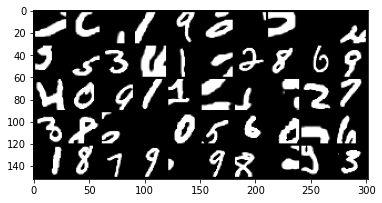

In [ ]:
##########################################################################
### Prepare the trainloader/testloader for training/validating network ###
##########################################################################

from   torchvision import datasets as datasets
import torchvision.transforms as transforms
import torch.utils as utils
import matplotlib.pyplot as plt
import torch
import torchvision

# The 「transform」 is used to 
# i)  convert PIL.Image to torch.FloatTensor (batch, dim, H, W), and change the 
#     inputs' range to [0, 1] (by inputs/= 255.0);
# ii) standardize the input images by mean=0.1307, std=0.3081
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

## trying various transforms to analyze their effects
transform1 = transforms.Compose([transforms.RandomAffine((-10.0, 10.0)),
                                 transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform2 = transforms.Compose([transforms.Resize((35,35)), transforms.RandomCrop(28), 
                                 transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform3 = transforms.Compose([transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),  
                                 transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform4 = transforms.Compose([transforms.RandAugment(num_ops=2),  
                                 transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform5 = transforms.Compose([transforms.RandomApply(transforms=[transforms.RandomAffine((-10.0, 10.0)),
                                                                    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
                                                                    transforms.RandAugment(num_ops=2)], p=0.5),
                                 transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform6 = transforms.Compose([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  
                                 transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform7 = transforms.Compose([transforms.RandomAdjustSharpness(sharpness_factor=2),
                                 transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
transform8 = transforms.Compose([transforms.RandomResizedCrop(size=(28, 28)),
                                 transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])


# Initialize dataloaders.
#limit_data  = 1000  # The first $limit_data samples
mnist_train = MyMNIST('./data', train=True,  download=True, transform=transform8, limit_data=1000)
mnist_test  = MyMNIST('./data', train=False, download=True, transform=transform8)
trainloader = utils.data.DataLoader(mnist_train, batch_size=50, shuffle=False,  num_workers=2)
testloader  = utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False, num_workers=2)



iter_data = iter(trainloader)
images, labels = next(iter_data)
print(images.size())
show_imgs = torchvision.utils.make_grid(images, nrow=10).numpy().transpose((1,2,0))
plt.imshow(show_imgs)

In [ ]:
# Initialize the network
#net = simple_network().cuda()
net = LeNet().cuda()

print(net)

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
)


In [ ]:
############################################
### Prepare the optimizer and loss func. ###
############################################

import torch.optim as optim
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters())
epoch = 0

In [ ]:
######################################################
#### ------ Script for evaluate the network ------ ###
######################################################

def evaluate_model():
  #print("Testing the network...")
  net.eval()
  total_num   = 0
  correct_num = 0
  for test_iter, test_data in enumerate(testloader):
    # Get one batch of test samples
    inputs, labels = test_data    
    bch = inputs.size(0)
    #inputs = inputs.view(bch, -1)

    # Move inputs and labels into GPU
    inputs = inputs.cuda()
    labels = torch.LongTensor(list(labels)).cuda()

    # Forward
    outputs = net(inputs)   

    # Get predicted classes
    _, pred_cls = torch.max(outputs, 1)
#     if total_num == 0:
#        print("True label:\n", labels)
#        print("Prediction:\n", pred_cls)
#     # Record test result
    correct_num+= (pred_cls == labels).float().sum().item()
    total_num+= bch
  net.train()
  
  #print("Accuracy: "+"%.3f"%(correct_num/float(total_num)))
  print("%.3f"%(correct_num/float(total_num)))

In [ ]:
#####################################################
### ------ Script for training the network ------ ###
#####################################################

epoch_size = 40
for epoch_idx in range(epoch_size):
  running_loss = 0.0
  ct_num = 0
  for iteration, data in enumerate(trainloader):
    # Take the inputs and the labels for 1 batch.
    inputs, labels = data
    bch = inputs.size(0)
    #inputs = inputs.view(bch, -1) <-- We don't need to reshape inputs here (we are using CNNs).
  
    # Move inputs and labels into GPU
    inputs = inputs.cuda()
    labels = labels.cuda()

    # Remove old gradients for the optimizer.
    optimizer.zero_grad()

    # Compute result (Forward)
    outputs = net(inputs)

    # Compute loss
    loss    = loss_func(outputs, labels)

    # Calculate gradients (Backward)
    loss.backward()

    # Update parameters
    optimizer.step()
  
    #with torch.no_grad():
    running_loss += loss.item()
    ct_num+= 1
    #if iteration%50 == 49:
    #if iteration%300 == 299:
      #print("Iteration: "+str(iteration+1)+", Loss: "+str(running_loss/ct_num)+'.')
      #print("[Epoch: "+str(epoch+1)+"]"" --- Iteration: "+str(iteration+1)+", Loss: "+str(running_loss/ct_num)+'.')
    # Test
    #if iteration%300 == 299:
    if iteration%20 == 19 and epoch%4 == 3:
      evaluate_model()
        
  epoch += 1

0.458
0.541
0.589
0.612
0.639
0.659
0.676
0.681
0.691
0.695


In [ ]:
evaluate_model()

Testing the network...
Accuracy: 0.84
